In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset
dataset = load_dataset('imagefolder', data_dir='/kaggle/input/chest-x-ray-images-pneumonia-augmented/All_Data', split='train')
dataset

Resolving data files:   0%|          | 0/9998 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 9998
})

In [4]:
split_1 = dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)

In [5]:
split_1

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7998
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
})

In [6]:
split_2 = split_1['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)

In [7]:
split_2

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [8]:
train_ds = split_1['train']
test_ds = split_2['test']
val_ds = split_2['train']

In [9]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 7998
})

In [10]:
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})

In [11]:
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})

In [12]:
labels = train_ds.features['label'].names
labels

['NORMAL', 'PNEUMONIA']

In [13]:
label2id,id2label = dict(),dict()
for i,label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [14]:
label2id['PNEUMONIA']


1

In [15]:
id2label[1]

'PNEUMONIA'

In [16]:
!pip install transformers

In [17]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

processor

2025-05-13 00:07:35.465168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747094855.488174     144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747094855.495074     144 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

In [18]:
!pip install torchvision

In [19]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_test(example_batch):
    example_batch['pixel_values'] = [val_transforms(image.convert("RGB")) for image in example_batch['image']]
    return example_batch

In [20]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_test)

In [21]:
train_ds[0]


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1288x776>,
 'label': 1,
 'pixel_values': tensor([[[ 0.0398,  0.0569,  0.0056,  ...,  0.9646,  0.9474,  0.9474],
          [ 0.0569, -0.0116,  0.0056,  ...,  0.9817,  0.9817,  0.9817],
          [ 0.0056, -0.0287, -0.0116,  ...,  0.9817,  0.9817,  0.9817],
          ...,
          [-0.4568, -0.4739, -0.5424,  ...,  0.7933,  0.7933,  0.7762],
          [-0.3883, -0.4739, -0.5082,  ...,  0.7933,  0.8104,  0.7933],
          [-0.3712, -0.5253, -0.5767,  ...,  0.7933,  0.8276,  0.8104]],
 
         [[ 0.1702,  0.1877,  0.1352,  ...,  1.1155,  1.0980,  1.0980],
          [ 0.1877,  0.1176,  0.1352,  ...,  1.1331,  1.1331,  1.1331],
          [ 0.1352,  0.1001,  0.1176,  ...,  1.1331,  1.1331,  1.1331],
          ...,
          [-0.3375, -0.3550, -0.4251,  ...,  0.9405,  0.9405,  0.9230],
          [-0.2675, -0.3550, -0.3901,  ...,  0.9405,  0.9580,  0.9405],
          [-0.2500, -0.4076, -0.4601,  ...,  0.9405,  0.9755,  0.9580]],

In [22]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    'facebook/dinov2-base',
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model_name = 'dinov2-Base'
batch_size = 4

In [24]:
import transformers
print(transformers.__version__)

4.51.1


In [25]:
import accelerate
print(accelerate.__version__)

1.3.0


In [26]:
!pip install torch

In [27]:
import torch
from accelerate import Accelerator

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")

# Use accelerate to get device info
accelerator = Accelerator()
print("Accelerator device:", accelerator.device)

CUDA available: True
GPU: Tesla P100-PCIE-16GB
Accelerator device: cuda


In [41]:
from transformers import TrainingArguments

args = TrainingArguments(
    f"{model_name}-finetuned-chest_xray",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    disable_tqdm=False
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [29]:
!pip install evaluate

In [42]:
import evaluate

# Load the accuracy and F1 metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [43]:
import numpy as np
def compute_metrics(eval_pred):
    """Computes accuracy, F1 score, and confusion matrix on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = eval_pred.label_ids

    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=references)['accuracy']

    # Compute F1 score
    f1 = f1_metric.compute(predictions=predictions, references=references, average="weighted")['f1']


    return {
        "accuracy": accuracy,
        "f1": f1,
    }

In [44]:
#is used to combine pixel values and their corresponding labels into a batch of data ready for training.
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {'pixel_values':pixel_values,'labels':labels}

In [45]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

/tmp/ipykernel_144/3406957794.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [46]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [47]:
from tqdm.notebook import tqdm

In [48]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.616800,0.309740,0.881000,0.880431
2,0.406400,0.229882,0.931000,0.930895
3,0.201100,0.190420,0.943000,0.942999
4,0.148000,0.221317,0.940000,0.939894
5,0.249500,0.251800,0.933000,0.932766
6,0.192600,0.115453,0.966000,0.965997
7,0.156500,0.171130,0.959000,0.958991
8,0.188100,0.123502,0.967000,0.966996
9,0.139000,0.128461,0.970000,0.969994
10,0.131700,0.115496,0.978000,0.977999


In [50]:
trainer.save_model()
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 7607980205GF
  train_loss               =       0.1998
  train_runtime            =   1:16:12.28
  train_samples_per_second =       17.492
  train_steps_per_second   =        1.094


In [51]:
metrics = trainer.evaluate()
trainer.log_metrics('eval',metrics)
trainer.save_metrics("eval",metrics)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =      0.978
  eval_f1                 =      0.978
  eval_loss               =     0.1155
  eval_runtime            = 0:00:30.93
  eval_samples_per_second =     32.322
  eval_steps_per_second   =      8.081


In [52]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.0860971212387085, 'test_accuracy': 0.98, 'test_f1': 0.97999799979998, 'test_runtime': 36.6877, 'test_samples_per_second': 27.257, 'test_steps_per_second': 6.814}


In [53]:
torch.save(model.state_dict(), f='custom_weights.pt')

In [55]:
from huggingface_hub import notebook_login
notebook_login()

In [56]:
trainer.push_to_hub('chest_xray')

events.out.tfevents.1747094915.14395f758a70.144.0:   0%|          | 0.00/5.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

events.out.tfevents.1747094399.14395f758a70.31.0:   0%|          | 0.00/9.51k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

events.out.tfevents.1747101735.14395f758a70.144.2:   0%|          | 0.00/457 [00:00<?, ?B/s]

events.out.tfevents.1747096012.14395f758a70.144.1:   0%|          | 0.00/115k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Haaaaaaaaaax/dinov2-Base-finetuned-chest_xray/commit/71d089660aff38437598e1d99e485d3703a1c151', commit_message='chest_xray', commit_description='', oid='71d089660aff38437598e1d99e485d3703a1c151', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Haaaaaaaaaax/dinov2-Base-finetuned-chest_xray', endpoint='https://huggingface.co', repo_type='model', repo_id='Haaaaaaaaaax/dinov2-Base-finetuned-chest_xray'), pr_revision=None, pr_num=None)

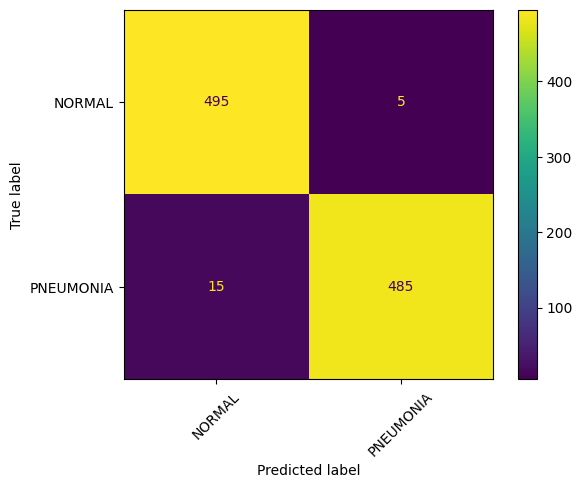

In [57]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = train_ds.features['label'].names
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(xticks_rotation=45)

In [58]:
from sklearn.metrics import recall_score

recall = recall_score(y_true,y_pred,average=None)
for label,score in zip(labels,recall):
    print(f"Recall for {label}: {score:.2f}")

Recall for NORMAL: 0.99
Recall for PNEUMONIA: 0.97


In [59]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix


# Calculate precision and recall for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

# Calculate specificity for each class
specificities = []
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
for i, label in enumerate(labels):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificities.append(specificity)

# Calculate overall metrics
overall_precision = precision_score(y_true, y_pred, average='weighted')
overall_recall = recall_score(y_true, y_pred, average='weighted')
overall_specificity = np.mean(specificities)  # Average specificity across all classes

# Print overall metrics
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")
print(f"Overall Specificity: {overall_specificity:.2f}")
print("************************************************************************************")

# Print precision, recall, and specificity for each label
for label, prec, rec, spec in zip(labels, precision, recall, specificities):
    print(f"Class '{label}': Precision = {prec:.2f}, Recall = {rec:.2f}, Specificity = {spec:.2f}")


Overall Precision: 0.98
Overall Recall: 0.98
Overall Specificity: 0.98
************************************************************************************
Class 'NORMAL': Precision = 0.97, Recall = 0.99, Specificity = 0.97
Class 'PNEUMONIA': Precision = 0.99, Recall = 0.97, Specificity = 0.99


In [60]:
predictions = trainer.predict(test_ds)

# Convert lists back to arrays for plotting
predictions_array = np.array(predictions.predictions)
references_array = np.array(predictions.label_ids)

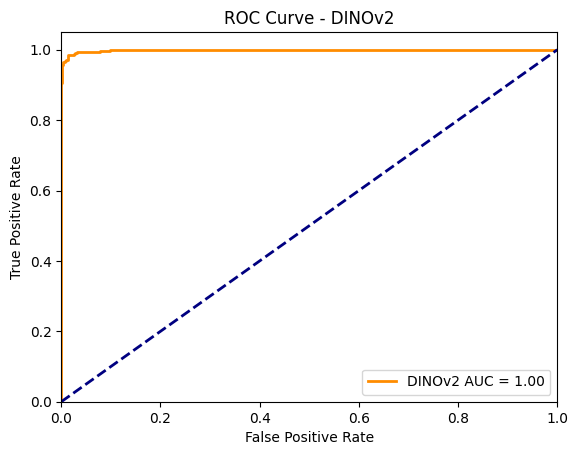

In [64]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming:
# - predictions_array is shape (num_samples, 2) with class probabilities
# - references_array contains true labels as integers (0 or 1)

# Use the probability for class 1 (positive class)
y_score = predictions_array[:, 1]
y_true = references_array

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'DINOv2 AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DINOv2')
plt.legend(loc="lower right")
plt.show()

# Inference

In [66]:
# Load model directly
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("Haaaaaaaaaax/dinov2-Base-finetuned-chest_xray")
model = AutoModelForImageClassification.from_pretrained("Haaaaaaaaaax/dinov2-Base-finetuned-chest_xray")
# Load an image
image_path = "/kaggle/input/chest-x-ray-images-pneumonia-augmented/All_Data/PNEUMONIA/PNEUMONIA_original_person104_virus_191.jpeg_f78ca812-60e2-469f-9fc3-40bc82f1aff7.jpeg"  # Replace with your image path
image = Image.open(image_path)  # Ensure it's in RGB format

# Preprocess the image
inputs = processor(images=image, return_tensors="pt") # return pythorch tensor

# Perform inference
with torch.no_grad(): #stop training
    outputs = model(**inputs)

# Get the predicted label
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = predictions.argmax().item()

# Map the predicted class index to a label
labels = model.config.id2label
predicted_label = labels[predicted_class]

print(f"Predicted label: {predicted_label}")


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Predicted label: PNEUMONIA
